In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../..")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from ycbv_loader import YCBVDataset

In [2]:
class YCBVConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'ycb'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1 + 21
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    TRAIN_ROIS_PER_IMAGE = 100
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5
    
config = YCBVConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                34
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
data_dir = os.path.join(ROOT_DIR, 'randomized_data')
dataset_train = YCBVDataset(data_dir, split='train')
dataset_train.load_ycbv()
dataset_train.prepare()

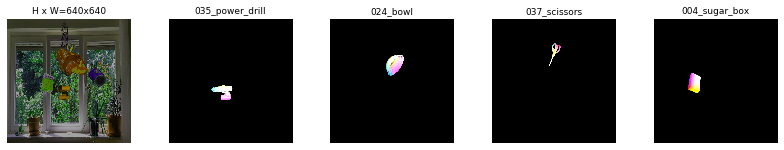

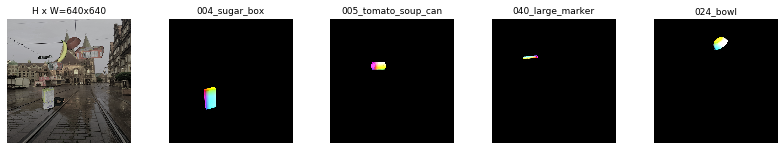

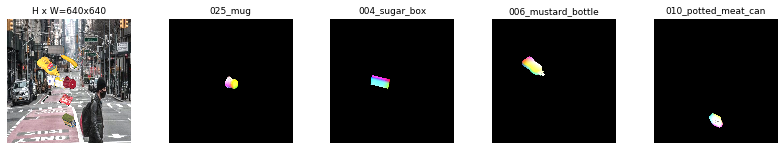

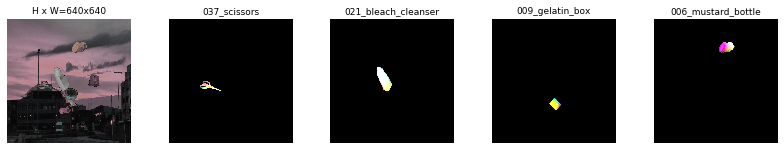

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    masks, class_ids = dataset_train.load_rgb_mask(image_id)
    visualize.display_rgb_top_masks(image, masks, class_ids, dataset_train.class_names)

image                    shape: (640, 640, 3)         min:    0.00000  max:  195.00000  uint8
mask                     shape: (640, 640, 21)        min:    0.00000  max:  255.00000  uint8
class_ids                shape: (7,)                  min:    4.00000  max:   17.00000  int32
bbox                     shape: (21, 4)               min:  133.00000  max:  522.00000  int32


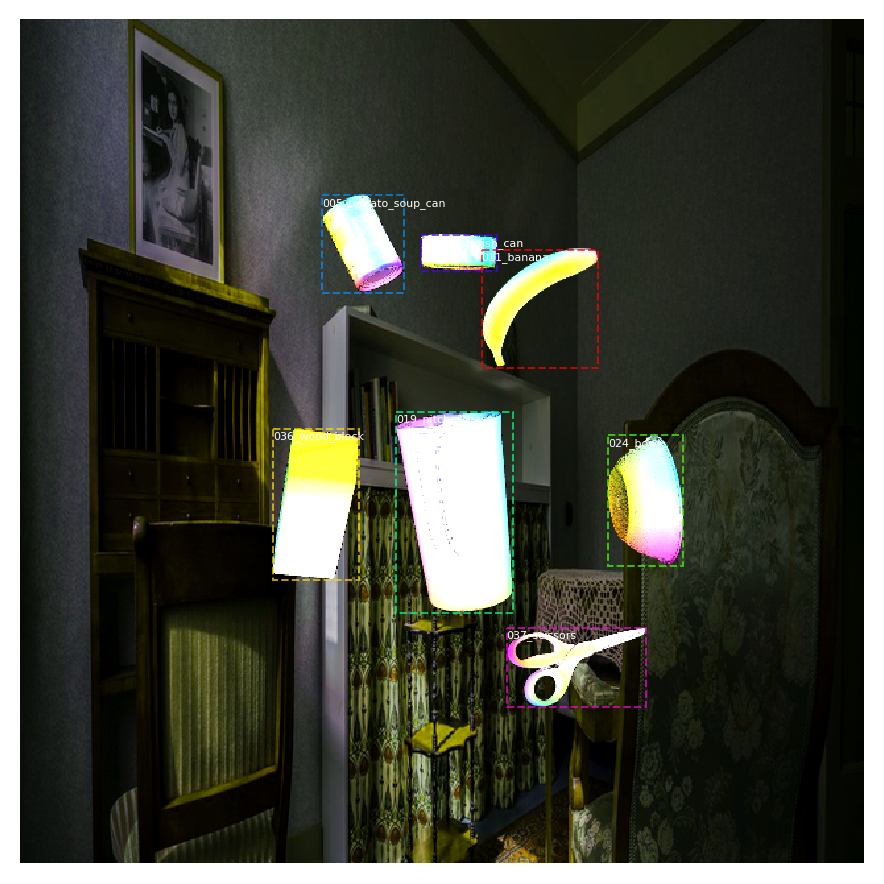

In [5]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_rgb_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)
# Display image and additional stats
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
visualize.display_rgb_instances(image, bbox, mask, class_ids, dataset_train.class_names)